In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(f):
    fixprice = lambda x: float(x.replace(',', '.'))
    df = pd.read_csv(f)
    if "Gmt time" in df.columns:
        df['Date'] = pd.to_datetime(df['Gmt time'], format="%d.%m.%Y %H:%M:%S.%f")
    elif "time" in df.columns:
        df['Date'] = pd.to_datetime(df['time'], unit="s")
        df['Date'] = df['Date'] + np.timedelta64(3 * 60, "m")
        df[['Date', 'Open', 'High', 'Low', 'Close']] = df[['Date', 'open', 'high', 'low', 'close']]
        df = df[['Date', 'Open', 'High', 'Low', 'Close']]
    elif "Tarih" in df.columns:
        df['Date'] = pd.to_datetime(df['Tarih'], format="%d.%m.%Y")
        df['Open'] = df['Açılış'].apply(fixprice)
        df['High'] = df['Yüksek'].apply(fixprice)
        df['Low'] = df['Düşük'].apply(fixprice)
        df['Close'] = df['Şimdi'].apply(fixprice)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

In [3]:
def plot_candles(df, ax, l=0):
    """
        Plots candles
        l: plot last n candles. If set zero, draw all
    """
    db = df.copy()
    if l > 0:
        db = db[-l:]
    db = db.reset_index(drop=True).reset_index()
    db["Up"] = db["Close"] > db["Open"]
    db["Bottom"] = np.where(db["Up"], db["Open"], db["Close"])
    db["Bar"] = db["High"] - db["Low"]
    db["Body"] = abs(db["Close"] - db["Open"])
    db["Color"] = np.where(db["Up"], "g", "r")
    ax.yaxis.tick_right()
    ax.bar(db["index"], bottom=db["Low"], height=db["Bar"], width=0.1, color="#000000")
    ax.bar(db["index"], bottom=db["Bottom"], height=db["Body"], width=0.35, color=db["Color"])
    t = 0.5
    ax.plot(db["Q0"], color="r", ls="-.", alpha=t)
    ax.plot(db["Q1"], color="g", alpha=t)
    ax.plot(db["Q2"], color="b", alpha=t)
    ax.plot(db["Q3"], color="g", alpha=t)
    ax.plot(db["Q4"], color="r", ls="-.", alpha=t)

In [4]:
def add_data(df, sample_size, shf=False):
    col = df["Close"].shift(1)
    col = df["Open"]
    df["OC"] = (df["Close"] - col) / col
    # we are shifting to not to have lookahead bias in the data
    df["Q0"] = (col * (1 + df["OC"].shift(1).rolling(sample_size).quantile(0.0)))
    df["Q1"] = (col * (1 + df["OC"].shift(1).rolling(sample_size).quantile(0.25)))
    df["Q2"] = (col * (1 + df["OC"].shift(1).rolling(sample_size).quantile(0.5)))
    df["Q3"] = (col * (1 + df["OC"].shift(1).rolling(sample_size).quantile(0.75)))
    df["Q4"] = (col * (1 + df["OC"].shift(1).rolling(sample_size).quantile(1.0)))
    if shf:
        df["Diff"] = col - df["Q2"]
        df["Q0"] = df["Q0"] + df["Diff"]
        df["Q1"] = df["Q1"] + df["Diff"]
        df["Q2"] = df["Q2"] + df["Diff"]
        df["Q3"] = df["Q3"] + df["Diff"]
        df["Q4"] = df["Q4"] + df["Diff"]
    return df.dropna().reset_index(drop=True)

In [5]:
def hist(df):
    plt.figure(figsize=(16, 9))
    plt.hist(df["OC"], bins=300, alpha=0.5)
    plt.axvline(df["OC"].quantile(0.0), ls="-.", color="r")
    plt.axvline(df["OC"].quantile(0.25), ls="-.", color="g")
    plt.axvline(df["OC"].quantile(0.75), ls="-.", color="g")
    plt.axvline(df["OC"].quantile(1.0), ls="-.", color="r")
    plt.axvline(df["OC"].quantile(0.5), ls="-.", color="#000000")
    plt.show()
    print("Median (Q2):", df["OC"].median())
    print("Q3 - Q4:", df["OC"].quantile(1.0) - df["OC"].quantile(0.75))
    print("Q0 - Q1:", df["OC"].quantile(0.25) - df["OC"].quantile(0.0))

In [6]:
def iqr_stats(df, c1="Q1", c2="Q3"):
    col1 = df[c1]
    col2 = df[c2]
    db = df[(df["Close"] >= col1) & (df["Close"] <= col2)]
    r = len(db) / len(df) * 100
    print("{} - {}: {:.2f}%".format(c1, c2, r))

In [7]:
def forecast(df, open_price, sample_size):
    # don't shift if you are forecasting and if the last data is not the live data
    q1 = (open_price * (1 + df["OC"].rolling(sample_size).quantile(0.25))).iloc[-1]
    q3 = (open_price * (1 + df["OC"].rolling(sample_size).quantile(0.75))).iloc[-1]
    iqr = q3 - q1
    iqr_range = iqr / open_price * 100
    
    iqr_out = "IQR: {:.2f} - {:.2f}, Points: {:.2f}, Range: {:.2f}%".format(q1, q3, iqr, iqr_range)
    print(iqr_out)

In [8]:
sym = "TSLA"
period = "1d"
fl = "./{} {}.csv".format(period, sym)
df = load_file(fl)
sample_size = 1000
df = add_data(df, sample_size, shf=False)

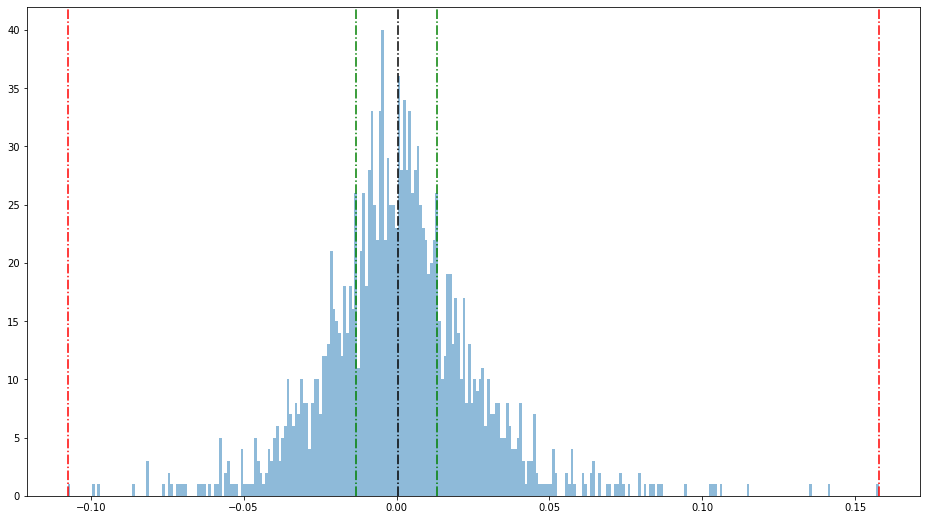

Median (Q2): 0.0003634114311573365
Q3 - Q4: 0.14448731927170932
Q0 - Q1: 0.09440655740813506


In [10]:
hist(df)

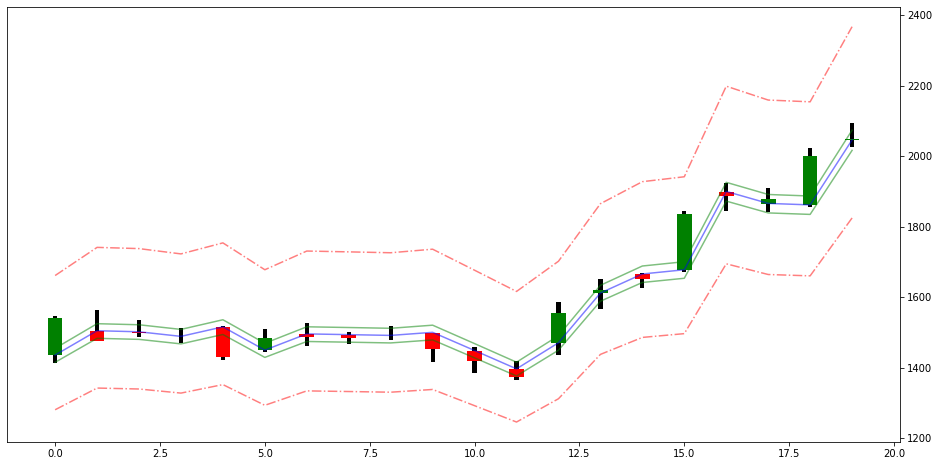

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
plot_candles(df, ax, 20)
plt.show()

In [12]:
iqr_stats(df, c1="Q1", c2="Q3")

Q1 - Q3: 51.16%


In [13]:
"""
Make sure that you have yesterday's data only.
Do not add live data to use forecast() function.
provide the open_price manually and get the IQR
"""
open_price = 2050
forecast(df, open_price, sample_size)

IQR: 2021.68 - 2079.12, Points: 57.44, Range: 2.80%
